# NYCU IEE Deep Learning Lab 01: Backpropagation
BSCHEN, 313510156

## Mount your google drive

In [20]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# You need to modify this part to the directory where your code is located
# %cd "/content/drive/MyDrive/Deep Learning/Homeworks/Lab 01"
%cd "/home/bschen/deep_learning/Lab_01"

/home/bschen/deep_learning/Lab_01


## Import packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd

In [3]:
# Fix the random seed
np.random.seed(0)

## Load the data and label

In [4]:
train_load = np.loadtxt('./data/fmnist-train.csv', delimiter=',', dtype="int")
train_data = train_load[:, 1:]
train_label = train_load[:, 0]
print(f"Shape of train_data: {train_data.shape}")
print(f"Shape of train_label: {train_label.shape}")

Shape of train_data: (60000, 784)
Shape of train_label: (60000,)


## Show the training data

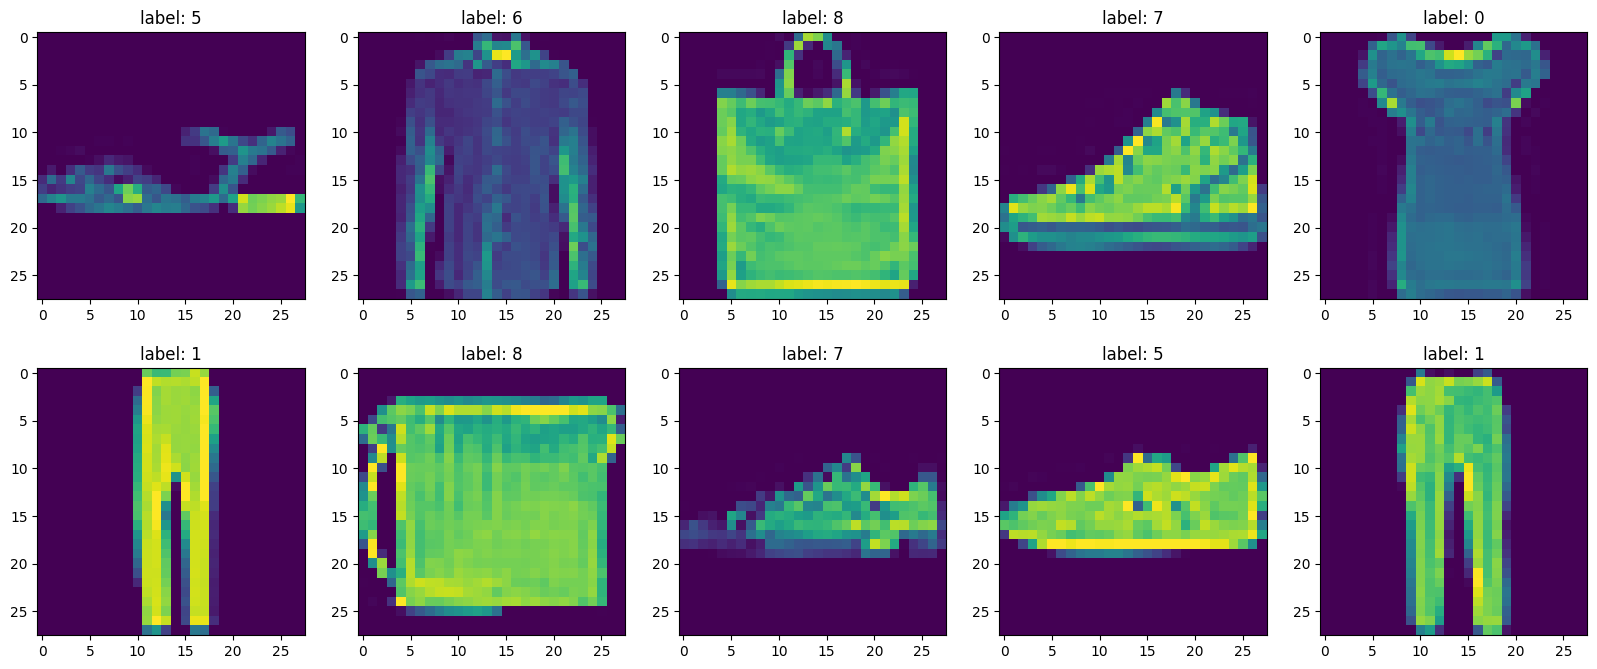

In [5]:
# Uncomment if you want to show the training data
plt.figure(figsize=(20, 8))
indices = np.random.choice(range(60000), size=10, replace=False).tolist()
for i, index in enumerate(indices):
    image = train_data[index].reshape(28, 28)
    plt.subplot(2, 5, i+1)
    plt.title(f"label: {train_label[index]}")
    plt.imshow(image)
plt.show()

## Change numpy array to pytorch tensor

In [6]:
train_image_num = train_data.shape[0]
train_data = train_data.astype('float32')

print(f"Number of training images is : {train_image_num}")

Number of training images is : 60000


In [7]:
train_data_tensor = torch.from_numpy(train_data)
train_label_tensor = torch.from_numpy(train_label)

## Validation image number

In [8]:
val_image_num = 10000

## Prepare for balance sampling in training dataset

In [9]:
# Sort by label (in-place)
train_set_label, sorted_indices = torch.sort(train_label_tensor[:-val_image_num])
train_data_tensor[:-val_image_num] = train_data_tensor[sorted_indices]
train_label_tensor[:-val_image_num] = train_label_tensor[sorted_indices]

# Start index of each class
class_start_index = []
num_classes = []
for c in range(10):
    indices = (train_label_tensor[:-val_image_num] == c)
    num_classes.append(indices.sum().item())
    class_start_index.append(torch.nonzero(indices)[0].item())

# Show information
print(f"Number of training images after split is : {train_data_tensor[:-val_image_num].shape[0]}")
print(f"Number of validation images is : {val_image_num}")
print(f"Number of images in each class (in training set): {num_classes}")
print(f"Start index of each class: {class_start_index}")

Number of training images after split is : 50000
Number of validation images is : 10000
Number of images in each class (in training set): [5015, 4999, 5009, 4978, 5032, 5017, 5012, 4994, 4990, 4954]
Start index of each class: [0, 5015, 10014, 15023, 20001, 25033, 30050, 35062, 40056, 45046]


## Convert labels to one hot vector


In [10]:
label_temp = np.zeros((train_image_num, 10), dtype=np.float32)
for i in range(train_image_num):
    label_temp[i][train_label[i]] = 1
train_label_onehot = np.copy(label_temp)
train_label_onehot_tensor = torch.from_numpy(train_label_onehot)
print(f"One-hot training labels shape: {train_label_onehot.shape}")

One-hot training labels shape: (60000, 10)


## Hyperparameters

In [ ]:
EPOCH = 150
BATCH_SIZE = 500  # 10000 should be divisible by batch_size
LEARNING_RATE = 1e-3

USE_GPU = True

## Define the models with pytorch

In [13]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolutional layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=1, padding=1),    # 28x28x1  -> 28x28x32
            nn.BatchNorm2d(32),
            nn.SiLU(inplace=True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),   # 28x28x32 -> 14x14x64
            nn.BatchNorm2d(64),
            nn.SiLU(inplace=True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),  # 14x14x64 -> 7x7x128
            nn.BatchNorm2d(128),
            nn.SiLU(inplace=True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1), # 7x7x128  -> 4x4x256
            nn.BatchNorm2d(256),
            nn.SiLU(inplace=True),
            nn.Flatten()                                 # 4x4x256  -> 4096
        )

        # Fully-connected layers
        self.fc1 = nn.Linear(4096, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.act = nn.SiLU(inplace=True)
        self.fc2 = nn.Linear(1024, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.encoder(x)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act(x)
        feat = self.fc2(x)
        x = self.bn2(feat)
        x = self.act(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.act(x)
        x = self.fc4(x)
        return x, feat


class CenterLoss(nn.Module):
    def __init__(self, num_classes, feat_dim, lambda_c=0.003, device='cpu'):
        super().__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.lambda_c = lambda_c
        self.centers = nn.Parameter(torch.randn(num_classes, feat_dim).to(device))

    def forward(self, features, labels):
        centers_batch = self.centers[labels]
        loss = (features - centers_batch).pow(2).sum(dim=1).mean()
        return self.lambda_c * loss


net = Net()

## Criterion and Optimizer

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
center_loss = CenterLoss(num_classes=10, feat_dim=256, device='cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)  # Do not update centers of center loss

## Training

In [15]:
import torch
import torch.nn.functional as F
import random

def preprocess(input_data: torch.Tensor, transform: bool=True) -> torch.Tensor:
    """ Normalize the input data and apply random transformations if specified. """
    batch_size = input_data.size(0)
    input_data = input_data.view(batch_size, 1, 28, 28)  # (batch, 1, 28, 28)
    input_data = input_data / 255.0 - 0.5
    if transform:
        input_data = random_transform(input_data)
    return input_data

def random_transform(input_data: torch.Tensor) -> torch.Tensor:
    """ Randomly apply cropping or horizontal flipping to each image in the batch. """
    transformed = []
    for img in input_data:
        op = np.random.choice(["shift", "flip", "rotate", "none"])
        if op == "flip":
            img = torch.flip(img, dims=[2])  # Horizontal flip

        elif op == "shift":
            pad = 6  # padding size
            padded = F.pad(img, (pad, pad, pad, pad), mode="constant", value=-0.5)
            x = random.randint(0, 2 * pad)
            y = random.randint(0, 2 * pad)
            img = padded[:, y:y+28, x:x+28]

        elif op == "rotate":
            angle = random.uniform(-10, 10) * np.pi / 180.0  # rad to deg
            cos_a, sin_a = np.cos(angle), np.sin(angle)

            theta = torch.tensor([
                [cos_a, -sin_a, 0.0],
                [sin_a,  cos_a, 0.0]
            ], dtype=torch.float32).unsqueeze(0)

            grid = F.affine_grid(theta, img.unsqueeze(0).size(), align_corners=False)
            img = F.grid_sample(img.unsqueeze(0), grid, align_corners=False).squeeze(0)

        # Brightness/Contrast adjustment
        brightness_factor = random.uniform(-0.2, 0.2)
        contrast_factor = random.uniform(0.8, 1.2)
        img = (img - img.mean()) * contrast_factor + img.mean() + brightness_factor
        img = torch.clamp(img, -0.5, 0.5)

        transformed.append(img)

    # Convert back to tensor
    transformed = torch.stack(transformed, dim=0)
    return transformed


In [ ]:
import time

# --------------------------------------------------------------------------------------------- #
# Move to GPU
device = torch.device("cuda") if torch.cuda.is_available() and USE_GPU else torch.device("cpu")
if device.type == "cuda":
    print("Using GPU")

net = net.to(device)
train_data_tensor = train_data_tensor.to(device)
train_label_tensor = train_label_tensor.to(device)
train_label_onehot_tensor = train_label_onehot_tensor.to(device)
criterion = criterion.to(device)
# --------------------------------------------------------------------------------------------- #

train_batch_num = (train_image_num - val_image_num) // BATCH_SIZE
val_batch_num = (val_image_num) // BATCH_SIZE
num_per_classes = BATCH_SIZE // 10

for epoch in range(1, EPOCH+1):
    train_hit, val_hit = 0, 0
    total_train_loss, total_val_loss = 0.0, 0.0
    start_time = time.time()

    # Training
    net.train()
    for it in range(train_batch_num):
        input_data_index = []
        for cls in range(10):
            idx = np.random.randint(
                class_start_index[cls], class_start_index[cls] + num_classes[cls], size=num_per_classes
            )
            input_data_index.extend(idx)
        input_data_index = np.array(input_data_index)

        input_data = train_data_tensor[input_data_index]
        input_data = preprocess(input_data.cpu(), transform=True).to(device)

        outputs, feat = net(input_data)
        _, pred_index = torch.max(outputs, 1)
        train_hit += (pred_index == train_label_tensor[input_data_index]).sum().item()
        loss = criterion(outputs, train_label_onehot_tensor[input_data_index]) + center_loss(feat, train_label_tensor[input_data_index])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    # Validation
    net.eval()
    with torch.no_grad():
        for tit in range(train_batch_num, train_batch_num + val_batch_num):
            input_data = train_data_tensor[tit * BATCH_SIZE:(tit+1) * BATCH_SIZE]
            input_data = preprocess(input_data.cpu(), transform=False).to(device)

            outputs, _ = net(input_data)
            _, pred_index = torch.max(outputs, 1)
            val_hit += (pred_index == train_label_tensor[tit * BATCH_SIZE:(tit+1) * BATCH_SIZE]).sum().item()
            loss = criterion(outputs, train_label_onehot_tensor[tit * BATCH_SIZE:(tit+1) * BATCH_SIZE])

            total_val_loss += loss.item()

    center_loss.lambda_c *= 1.05 if center_loss.lambda_c < 0.005 and epoch % 10 == 0 and epoch != 0 else 1

    end_time = time.time()
    epoch_time = end_time - start_time
    print(
        f"Task-2  | Epoch:{epoch:3d} |",
        f"Train Loss:{total_train_loss / train_batch_num: 8.4f} |",
        f"Train Acc:{train_hit / (train_image_num - val_image_num) * 100.0: 3.4f} |",
        f"Val Loss:{total_val_loss / val_batch_num: 8.4f} |",
        f"Val Acc:{val_hit / val_image_num * 100.0: 3.4f} |",
        f"Epoch time:{epoch_time: 5.2f} sec"
    )

# --------------------------------------------------------------------------------------------- #
# Back to cpu
net = net.cpu()
train_data_tensor = train_data_tensor.cpu()
train_label_tensor = train_label_tensor.cpu()
train_label_onehot_tensor = train_label_onehot_tensor.cpu()
criterion = criterion.cpu()
# --------------------------------------------------------------------------------------------- #